# **MONAI 2D segmentation with swinUNETR**

In [2]:
#@title Run this cell once, then restart the runtime. Do not run again.
!pip install monai-weekly[nibabel]
!pip install einops
!pip install ITK
!pip install pytorch-ignite
!pip install transformers
!pip install mlflow
!pip install pynrrd version

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 2.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 85.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 MB 12.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-py

In [23]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
from monai.networks.nets import SwinUNETR
import logging
import os
import sys
import tempfile
from glob import glob

import torch
from PIL import Image
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import ArrayDataset, create_test_image_2d, decollate_batch, DataLoader
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    LoadImage,
    RandRotate90,
    RandSpatialCrop,
    ScaleIntensity,
)
from monai.visualize import plot_2d_or_3d_image
dim = 1024

def training(tempdir):
    monai.config.print_config()
    logging.basicConfig(stream=sys.stdout, level=logging.INFO)

    # create a temporary directory and 40 random image, mask pairs
    print(f"generating synthetic data to {tempdir} (this may take a while)")
    for i in range(40):
        im, seg = create_test_image_2d(dim , dim, num_seg_classes=1)
        Image.fromarray((im * 255).astype("uint8")).save(os.path.join(tempdir, f"img{i:d}.png"))
        Image.fromarray((seg * 255).astype("uint8")).save(os.path.join(tempdir, f"seg{i:d}.png"))

    images = sorted(glob(os.path.join(tempdir, "img*.png")))
    segs = sorted(glob(os.path.join(tempdir, "seg*.png")))

    # define transforms for image and segmentation
    train_imtrans = Compose(
        [
            LoadImage(image_only=True, ensure_channel_first=True),
            ScaleIntensity(),
            RandSpatialCrop((768,768), random_size=False),
            RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        ]
    )
    train_segtrans = Compose(
        [
            LoadImage(image_only=True, ensure_channel_first=True),
            ScaleIntensity(),
            RandSpatialCrop((768, 768), random_size=False),
            RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        ]
    )
    val_imtrans = Compose([LoadImage(image_only=True, ensure_channel_first=True), ScaleIntensity()])
    val_segtrans = Compose([LoadImage(image_only=True, ensure_channel_first=True), ScaleIntensity()])

    # define array dataset, data loader
    check_ds = ArrayDataset(images, train_imtrans, segs, train_segtrans)
    check_loader = DataLoader(check_ds, batch_size=10, num_workers=2, pin_memory=torch.cuda.is_available())
    im, seg = monai.utils.misc.first(check_loader)
    print(im.shape, seg.shape)

    # create a training data loader
    train_ds = ArrayDataset(images[:20], train_imtrans, segs[:20], train_segtrans)
    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=8, pin_memory=torch.cuda.is_available())
    # create a validation data loader
    val_ds = ArrayDataset(images[-20:], val_imtrans, segs[-20:], val_segtrans)
    val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, pin_memory=torch.cuda.is_available())
    dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
    post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
    # create UNet, DiceLoss and Adam optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = SwinUNETR(img_size=(dim ,dim ), in_channels=1, out_channels=1,  spatial_dims=2).to(device)
    loss_function = monai.losses.DiceLoss(sigmoid=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-3)

    # start a typical PyTorch training
    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = list()
    metric_values = list()
    writer = SummaryWriter()
    for epoch in range(10):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{10}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds) // train_loader.batch_size
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
            writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                val_images = None
                val_labels = None
                val_outputs = None
                for val_data in val_loader:
                    val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                    roi_size = (96, 96)
                    sw_batch_size = 4
                    val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                    val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)
                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()
                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), "best_metric_model_segmentation2d_array.pth")
                    print("saved new best metric model")
                print(
                    "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                        epoch + 1, metric, best_metric, best_metric_epoch
                    )
                )
                writer.add_scalar("val_mean_dice", metric, epoch + 1)
                # plot the last model output as GIF image in TensorBoard with the corresponding image and label
                plot_2d_or_3d_image(val_images, epoch + 1, writer, index=0, tag="image")
                plot_2d_or_3d_image(val_labels, epoch + 1, writer, index=0, tag="label")
                plot_2d_or_3d_image(val_outputs, epoch + 1, writer, index=0, tag="output")

    print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
    writer.close()


#if __name__ == "__main__":
    #with tempfile.TemporaryDirectory() as tempdir:
     #   main(tempdir)

In [24]:
with tempfile.TemporaryDirectory() as tempdir:
     training(tempdir)

MONAI version: 1.2.dev2306
Numpy version: 1.21.6
Pytorch version: 1.13.1+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 4fd4fb01b9f5e329f1efb55b52bdcd0d6f95497f
MONAI __file__: /usr/local/lib/python3.8/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
ITK version: 5.3.0
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.9.1
gdown version: 4.4.0
TorchVision version: 0.14.1+cu116
tqdm version: 4.64.1
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: 0.6.0
transformers version: 4.26.0
mlflow version: 2.1.1
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies

generating synthetic data to /tmp/tmpbajtyh5h (this may take a while)
torch.Size([10, 1, 768, 768]) torch.Size([10, 

In [16]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import logging
import os
import sys
import tempfile
from glob import glob

import torch
from PIL import Image

from monai import config
from monai.data import ArrayDataset, create_test_image_2d, decollate_batch, DataLoader
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import Activations, AsDiscrete, Compose, LoadImage, SaveImage, ScaleIntensity

dim = 1024
def evaluation(tempdir):
    config.print_config()
    logging.basicConfig(stream=sys.stdout, level=logging.INFO)

    print(f"generating synthetic data to {tempdir} (this may take a while)")
    for i in range(5):
        im, seg = create_test_image_2d(dim, dim, num_seg_classes=1)
        Image.fromarray((im * 255).astype("uint8")).save(os.path.join(tempdir, f"img{i:d}.png"))
        Image.fromarray((seg * 255).astype("uint8")).save(os.path.join(tempdir, f"seg{i:d}.png"))

    images = sorted(glob(os.path.join(tempdir, "img*.png")))
    segs = sorted(glob(os.path.join(tempdir, "seg*.png")))

    # define transforms for image and segmentation
    imtrans = Compose([LoadImage(image_only=True, ensure_channel_first=True), ScaleIntensity()])
    segtrans = Compose([LoadImage(image_only=True, ensure_channel_first=True), ScaleIntensity()])
    val_ds = ArrayDataset(images, imtrans, segs, segtrans)
    # sliding window inference for one image at every iteration
    val_loader = DataLoader(val_ds, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available())
    dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
    post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
    saver = SaveImage(output_dir="./output", output_ext=".png", output_postfix="seg")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SwinUNETR(img_size=(128,128), in_channels=1, out_channels=1,  spatial_dims=2).to(device)

    model.load_state_dict(torch.load("best_metric_model_segmentation2d_array.pth"))
    model.eval()
    with torch.no_grad():
        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
            # define sliding window size and batch size for windows inference
            roi_size = (96, 96)
            sw_batch_size = 4
            val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
            val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
            val_labels = decollate_batch(val_labels)
            # compute metric for current iteration
            dice_metric(y_pred=val_outputs, y=val_labels)
            for val_output in val_outputs:
                saver(val_output)
        # aggregate the final mean dice result
        print("evaluation metric:", dice_metric.aggregate().item())
        # reset the status
        dice_metric.reset()




In [25]:

with tempfile.TemporaryDirectory() as tempdir:
    evaluation(tempdir)


MONAI version: 1.2.dev2306
Numpy version: 1.21.6
Pytorch version: 1.13.1+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 4fd4fb01b9f5e329f1efb55b52bdcd0d6f95497f
MONAI __file__: /usr/local/lib/python3.8/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
ITK version: 5.3.0
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.9.1
gdown version: 4.4.0
TorchVision version: 0.14.1+cu116
tqdm version: 4.64.1
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: 0.6.0
transformers version: 4.26.0
mlflow version: 2.1.1
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies

generating synthetic data to /tmp/tmpd58el6cf (this may take a while)
2023-02-08 18:57:54,316 INFO image_writer.py:1

In [9]:
import matplotlib.pyplot as plt


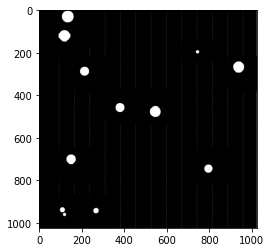

In [26]:
plot_im("output/img4/img4_seg.png")

In [7]:

import imageio

def plot_im (path):
   im = imageio.imread(path)
   plt.imshow(im,cmap='gray')
